In [1]:
import random
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from itertools import chain 

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.tensorboard import SummaryWriter

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
tensor = torch.rand(5,5)

if torch.backends.mps.is_available():
    tensor = tensor.to('mps')
print(f'Device: {tensor.device}')

Device: mps:0


In [3]:
device = 'mps'

In [4]:
train_set = torchvision.datasets.FashionMNIST("./data", download=False, 
                                              transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST("./data", download=False, train=False, 
                                             transform=transforms.Compose([transforms.ToTensor()])) 

In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

In [6]:
label_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    
    
label_type_converter = lambda label: (label_mapping[label.item()] if type(label) == torch.Tensor 
                                      else label_mapping[label])

In [7]:
a = next(iter(train_loader))

print(f'x-batch dimention: {a[0].size()}')
print(f'y-batch dimention: {a[1].size()}')

x-batch dimention: torch.Size([1000, 1, 28, 28])
y-batch dimention: torch.Size([1000])


Data raw label - 8
Data label - Bag


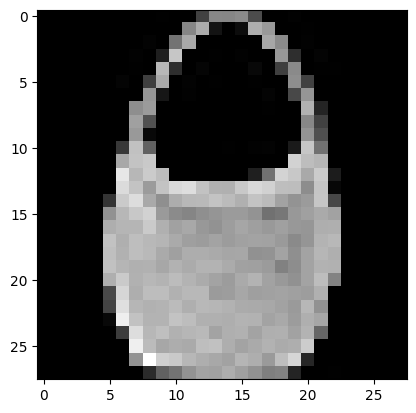

In [8]:
image, label = next(iter(train_loader))
indx = random.randrange(image.size()[0])

plt.imshow(image[indx].squeeze(), cmap="gray")

print(f'Data raw label - {label[indx]}')
print(f'Data label - {label_type_converter(label[indx])}')

In [9]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

In [21]:
class FC_1(nn.Module):
    def __init__(self):
        super(FC_1, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_stack(x)
        return logits

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (x,y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        
        logits = model(x)
        prob = nn.Softmax(dim=1)(logits)
        loss = loss_fn(prob, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')
    
    train_loss /= size
    
    return train_loss 

In [12]:
def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            
            logits = model(x)
            prob = nn.Softmax(dim=1)(logits)
            test_loss += loss_fn(prob, y).item()
            correct += (prob.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= size
    correct /= size
    
    print(f'Test error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    
    return test_loss, 100*correct

In [22]:
model = FC_1().to(device)

In [23]:
model

FC_1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [15]:
# Test inference
x = torch.rand(1, 28, 28, device=device)
logits = model(x)
prob = nn.Softmax(dim=1)(logits)

print(f'logits - {logits}')
print(f'prob - {prob}')

logits - tensor([[-0.0766, -0.0102,  0.0703,  0.0113,  0.0483, -0.0773, -0.0617, -0.0840,
          0.0016, -0.0303]], device='mps:0', grad_fn=<LinearBackward0>)
prob - tensor([[0.0945, 0.1009, 0.1094, 0.1031, 0.1070, 0.0944, 0.0959, 0.0938, 0.1021,
         0.0989]], device='mps:0', grad_fn=<SoftmaxBackward0>)


/Users/denis/my_dev/ml-playground/venv/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


In [24]:
# model = FC().to(device)
model = FC_1().to(device)

# agenda = '/fc:28x28/512x512/512x10'
agenda = '/fc_1:28x28/512x512/512x10'

learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [25]:
writer = SummaryWriter(comment=agenda)

epoch = 200

for t in range(epoch):
    print(f'Epoch {t+1}\n-----------------------')
    
    train_loss = train_loop(train_loader, model, loss_fn, optimizer)
    test_loss, avg_acc = val_loop(test_loader, model, loss_fn)

    writer.add_scalars('Losses', {'train': train_loss,
                                  'val'  : test_loss,}, t+1)
    writer.add_scalar('Accuracy/test', avg_acc, t+1)
    
writer.close()

Epoch 1
-----------------------
loss: 2.303159 [    0/60000]
Test error: 
 Accuracy: 56.1%, Avg loss: 0.001974 

Epoch 2
-----------------------
loss: 1.967485 [    0/60000]
Test error: 
 Accuracy: 68.2%, Avg loss: 0.001786 

Epoch 3
-----------------------
loss: 1.760753 [    0/60000]
Test error: 
 Accuracy: 75.3%, Avg loss: 0.001723 

Epoch 4
-----------------------
loss: 1.722840 [    0/60000]
Test error: 
 Accuracy: 77.1%, Avg loss: 0.001698 

Epoch 5
-----------------------
loss: 1.669718 [    0/60000]
Test error: 
 Accuracy: 77.8%, Avg loss: 0.001690 

Epoch 6
-----------------------
loss: 1.697715 [    0/60000]
Test error: 
 Accuracy: 78.6%, Avg loss: 0.001680 

Epoch 7
-----------------------
loss: 1.674252 [    0/60000]
Test error: 
 Accuracy: 79.4%, Avg loss: 0.001673 

Epoch 8
-----------------------
loss: 1.686059 [    0/60000]
Test error: 
 Accuracy: 79.5%, Avg loss: 0.001670 

Epoch 9
-----------------------
loss: 1.659249 [    0/60000]
Test error: 
 Accuracy: 79.9%, Avg 

Ground label    - Coat
Predicted label - Coat / prob:1.00


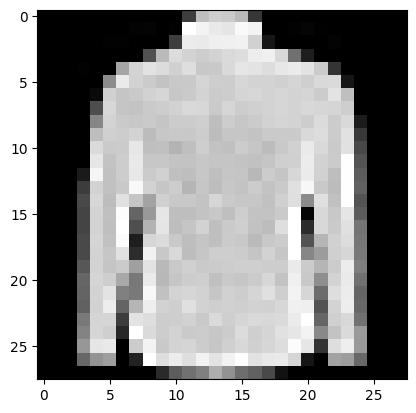

In [26]:
image, label = next(iter(test_loader))
indx = random.randrange(image.size()[0])

plt.imshow(image[indx].squeeze(), cmap="gray")

with torch.no_grad():
    x = image[indx]
    x = x.to(device)

    logits = model(x)
    prob = nn.Softmax(dim=1)(logits)
    
    prediction = prob.argmax(1)
    
    print(f'Ground label    - {label_type_converter(label[indx])}')
    print(f'Predicted label - {label_type_converter(prediction)} / prob:{prob[0][prob.argmax(1)].item():>0.2f}')

In [27]:
predictions = []
ground = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        prob = nn.Softmax(dim=1)(logits)
        
        predictions.append(prob.argmax(1))
        ground.append(y)

ground = [i.item() for i in list(chain.from_iterable(ground))]
predictions = [i.item() for i in list(chain.from_iterable(predictions))]

In [28]:
print(f'Classification report for {agenda}')
print(f'{metrics.classification_report(ground, predictions)}')

Classification report for /fc_1:28x28/512x512/512x10
              precision    recall  f1-score   support

           0       0.71      0.92      0.80      1000
           1       0.98      0.97      0.98      1000
           2       0.69      0.84      0.76      1000
           3       0.87      0.91      0.89      1000
           4       0.61      0.87      0.72      1000
           5       0.98      0.95      0.97      1000
           6       0.00      0.00      0.00      1000
           7       0.95      0.95      0.95      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.98      0.96      1000

    accuracy                           0.84     10000
   macro avg       0.77      0.84      0.80     10000
weighted avg       0.77      0.84      0.80     10000



/Users/denis/my_dev/ml-playground/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/denis/my_dev/ml-playground/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/denis/my_dev/ml-playground/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_